# Data Wrangling with Spark

This is the code used in the previous screencast. Run each code cell to understand what the code does and how it works.

These first three cells import libraries, instantiate a SparkSession, and then read in the data set

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [3]:
path = "data/sparkify_log_small.json"
user_log = spark.read.json(path)

# Data Exploration 

The next cells explore the data set.

In [4]:
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+------------------+--------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|             10000|  

In [7]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [9]:
user_log.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|             8347|
|   mean|249.6486587492503|
| stddev|95.00437130781461|
|    min|          1.12281|
|    max|        1806.8371|
+-------+-----------------+



In [10]:
user_log.count()

10000

In [11]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [12]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").count()

30

# Calculating Statistics by Hour

In [13]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [14]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [15]:
user_log.show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|  22|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+----------

In [16]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [17]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  456|
|   1|  454|
|   2|  382|
|   3|  302|
|   4|  352|
|   5|  276|
|   6|  348|
|   7|  358|
|   8|  375|
|   9|  249|
|  10|  216|
|  11|  228|
|  12|  251|
|  13|  339|
|  14|  462|
|  15|  479|
|  16|  484|
|  17|  430|
|  18|  362|
|  19|  295|
+----+-----+
only showing top 20 rows



In [18]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

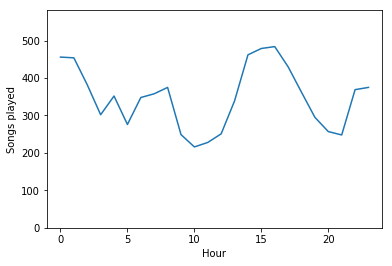

In [20]:
plt.plot(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [21]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [22]:
user_log_valid.count()

10000

In [24]:
user_log.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
+------+
only showing top 10 rows



In [25]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [26]:
user_log_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [28]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  11|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [41]:
import pyspark.sql.functions as func

In [53]:
user_log\
    .filter(user_log.userId != '')\
    .groupby("userId", "hour")\
    .agg(func.count("userId")\
                 .alias("num_sessions"))\
    .orderBy(desc("num_sessions"))\
    .show(10)

+------+----+------------+
|userId|hour|num_sessions|
+------+----+------------+
|    58|   3|          31|
|    58|   2|          28|
|  1806|  22|          23|
|  1611|  18|          21|
|  1865|   8|          20|
|  1107|   7|          20|
|  1777|   7|          20|
|   590|  21|          20|
|   649|   6|          20|
|    58|  23|          19|
+------+----+------------+
only showing top 10 rows



In [47]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "58").count()

313

In [51]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [52]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [54]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22', downgraded=0)

In [55]:
from pyspark.sql import Window

In [56]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [57]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [58]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs